Test with: cpu
1. Recipro CAM Execution Time:  0.7216160297393799  :  21


/var/folders/g6/hgylk7_d0179yjj7zv32737m0000gn/T/ipykernel_20012/3581761227.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


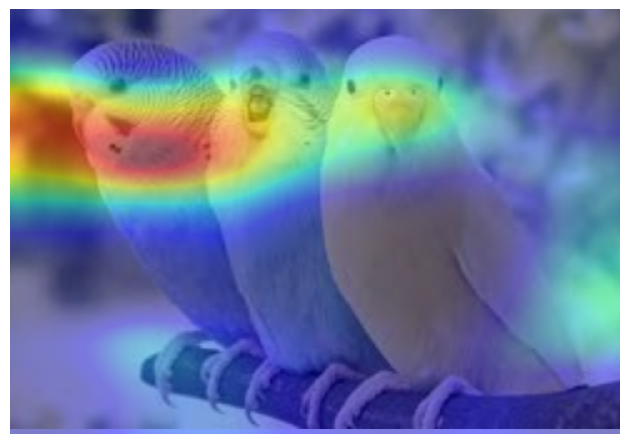

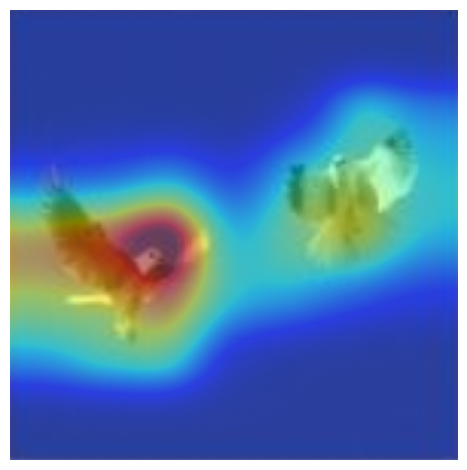

In [ ]:
import time
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.transforms.functional import to_pil_image

from src.recipro_cam import *

# Function to create heatmap overlay
def overlay_heatmap(img: Image.Image, mask: Image.Image, colormap: str = "jet", alpha: float = 0.7) -> Image.Image:
    """Overlay a colormapped mask on a background image

    Args:
        img: background image
        mask: mask to be overlayed in grayscale
        colormap: colormap to be applied on the mask
        alpha: transparency of the background image

    Returns:
        overlayed image
    """
    
    cmap = cm.get_cmap(colormap)
    # Resize mask and apply colormap
    overlay = mask.resize(img.size, resample=Image.BICUBIC)
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
    # Overlay the image with the mask
    overlayed_img = Image.fromarray((alpha * np.asarray(img) + (1 - alpha) * overlay).astype(np.uint8))

    return overlayed_img
    

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Test with: {device}")

model = models.resnet50(pretrained=True).to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_file_names = ['/Users/markbyun/Desktop/Projects/ReciproCam/data/bird_image1.png',
                    '/Users/markbyun/Desktop/Projects/ReciproCam/data/bird_image2.png']
images = []
for i in range(len(input_file_names)):
    img = Image.open(input_file_names[i])
    images.append(img)
    i_tensor = transform(img).unsqueeze(0)
    if i > 0:
        input_tensor = torch.cat((input_tensor, i_tensor), dim=0)
    else:
        input_tensor = i_tensor
input_tensor = input_tensor.to(device)


def recipro_cam_test():

    #torch_cam like hook method
    begin_time = time.time()
    recipro_cam = ReciproCam(model, device=device)
    cam, class_id = recipro_cam(input_tensor)
    last_time = time.time()
    print('1. Recipro CAM Execution Time: ', last_time - begin_time, ' : ', class_id)

    for i in range(len(cam)):
        img = np.asarray(images[i])
        #result = overlay_mask(to_pil_image(img), to_pil_image(cam[i].detach(), mode='F'), alpha=0.5)
        result = overlay_heatmap(to_pil_image(img), to_pil_image(cam[i].detach(), mode='F'), alpha=0.5)
        plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()
        filename = f'./cam_results/test{i}.png'
        result.save(filename)

    return 
    

if __name__ == '__main__':
    recipro_cam_test()

